# Notebook for testing own functions

In [1]:
import random
from pprint import pprint
from pathlib import Path

import pandas as pd

from itertools import product
import itertools

from matplotlib import pyplot as plt


import Levenshtein as lev
from Levenshtein import distance as levdist
from Levenshtein import hamming as hamming

## Import own things

In [2]:
from dnctree.tree import Tree
from dnctree.partialdistancematrix import PartialDistanceMatrix

# import init_module    # init_module was a copy of __init__.py used for accessing dnc_tree

from dnctree.dnctree_k import (
    dnc_neighborjoining_with_weights,
    get_longest_path_length_to_leaf,
    get_center_vertex,
    get_weights_to_leaves,
    get_clades_and_dists_to_center,
    dnc_tree_k
)

In [3]:
%load_ext autoreload
%autoreload 2

## Output nodes, edges and weights to be used with *csacademy* graph editor

In [4]:
def write_graph_data(t: Tree, dm: PartialDistanceMatrix):
    """
    Write the tree with edge weights to a file. Each line is of the form:
    node1 node2 weight
    This data can be plotted with `https://csacademy.com/app/graph_editor/`
    """
    lines = []

    for node, edges in t.adjacencies.items():
        for neighbour in edges:
            # print(f"{node} {neighbour}")
            if node in dm._dm and neighbour in dm._dm[node]:
                weight = f"{dm._dm[node][neighbour]:.2f}"
            else:
                weight = ""
            lines.append(f"{node} {neighbour} {weight}".strip())

    print(f"Number of lines: {len(lines)}")
    text = "\n".join(lines)
    _ = (Path.home() / "temp" / "dnc_neighborjoining.txt").write_text(text)

## Mock MSA

In [5]:
class MockDistMSA:
    """
    A mock MSA class where taxa is specified with a matrix containing all pairwise distances.
    """
    def __init__(self, distances):
        """
        """
        self._taxa = [f"T_{i}" for i in range(len(distances))]
        self.distances = distances

    def can_retrieve_distances(self) -> bool:
        return True

    def distance(self, taxon1, taxon2):
        i = int(taxon1[2:])
        j = int(taxon2[2:])
        return float(self.distances[i][j])

    def taxa(self):
        return self._taxa

    def distance_matrix(self):
        """
        Not needed but for visualisation and debugging purposes.
        """
        df = pd.DataFrame(index=self.taxa(), columns=self.taxa())
        for taxon1, taxon2 in product(self.taxa(), self.taxa()):
            df.loc[taxon1, taxon2] = self.distance(taxon1, taxon2)
        return df

## Build a test tree

In [6]:
class TestDistanceMatrix:
    """
    A minmal implementation of the partial distance matrix that supports only get and set methods.

    Used for testing purposes.
    """
    def __init__(self):
        self._dm = {}
    
    def set(self, x, y, dist):
        if x not in self._dm:
            self._dm[x] = {}
        if y not in self._dm:
            self._dm[y] = {}
        self._dm[x][y] = dist
        self._dm[y][x] = dist
    
    def get(self, x, y):
        return self._dm[x][y]

In [7]:
# Test tree

taxa_distances = [
    [0, 20, 50, 50, 100, 60, 50, 60],
    [20, 0, 50, 50, 80, 40, 70, 40],
    [50, 50, 0, 40, 50, 10, 80, 30],
    [50, 50, 40, 0, 50, 50, 40, 50],
    [100, 80, 50, 50, 0, 40, 50, 40],
    [60, 40, 10, 50, 40, 0, 90, 20],
    [50, 70, 80, 40, 50, 90, 0, 90],
    [60, 40, 30, 50, 40, 20, 90, 0],
]

edges = [
    ("T_0", "#0", 13),
    ("T_1", "#0", 7),
    ("T_3", "#1", 7),
    ("T_6", "#1", 33),
    ("T_2", "#3", 8),
    ("T_5", "#3", 2),
    ("T_4", "#4", 27),
    ("T_7", "#5", 12),
    ("#0", "#2", 16),
    ("#1", "#2", 9),
    ("#2", "#4", 15),
    ("#3", "#5", 6),
    ("#4", "#5", 3),
]

dm = TestDistanceMatrix()
for i in range(8):
    for j in range(8):
        dm.set(f"T_{i}", f"T_{j}", taxa_distances[i][j])

tree = Tree()
for x, y, dist in edges:
    tree.add_edge(x, y)
    dm.set(x, y, dist)

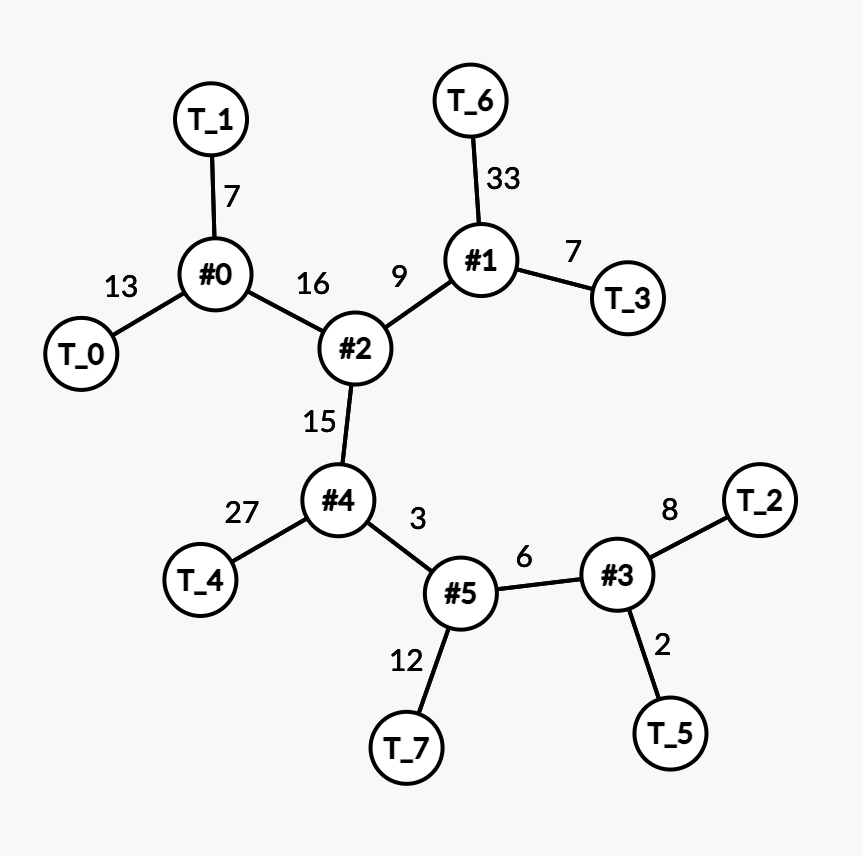

In [8]:
from IPython.display import Image

# Tree generated with https://csacademy.com/app/graph_editor/
Image("../amy_test_tree.png", width=300)

## Unit tests of various functions

Testing various functions on the tree specified above.

In [9]:
# Verify longest path from edge to leaves.

lengths = {}
assert get_longest_path_length_to_leaf(tree, lengths, ("T_6", "#1")) == 6
assert get_longest_path_length_to_leaf(tree, lengths, ("#1", "T_6")) == 1
assert get_longest_path_length_to_leaf(tree, lengths, ("#2", "#4")) == 4
assert get_longest_path_length_to_leaf(tree, lengths, ("#3", "#5")) == 5
assert get_longest_path_length_to_leaf(tree, lengths, ("#2", "#0")) == 2

assert get_center_vertex(tree) == "#4"

In [10]:
assert get_weights_to_leaves(tree, dm, ("#4", "#5")) == (
    ["T_7", "T_2", "T_5"],
    [15, 17, 11],
)
assert get_weights_to_leaves(tree, dm, ("#4", "#2")) == (
    ["T_0", "T_1", "T_3", "T_6"],
    [44, 38, 31, 57],
)
assert get_weights_to_leaves(tree, dm, ("#4", "T_4")) == (["T_4"], [27])
assert get_weights_to_leaves(tree, dm, ("#5", "#3")) == (["T_2", "T_5"], [14, 8])

In [11]:
assert get_clades_and_dists_to_center(tree, dm, "#4") == (
    {0: ["T_4"], 1: ["T_0", "T_1", "T_3", "T_6"], 2: ["T_7", "T_2", "T_5"]},
    {"T_4": 0, "T_0": 1, "T_1": 1, "T_3": 1, "T_6": 1, "T_7": 2, "T_2": 2, "T_5": 2},
    {
        "T_4": 27,
        "T_0": 44,
        "T_1": 38,
        "T_3": 31,
        "T_6": 57,
        "T_7": 15,
        "T_2": 17,
        "T_5": 11,
    },
)
assert get_clades_and_dists_to_center(tree, dm, "#5") == (
    {0: ["T_7"], 1: ["T_2", "T_5"], 2: ["T_4", "T_0", "T_1", "T_3", "T_6"]},
    {"T_7": 0, "T_2": 1, "T_5": 1, "T_4": 2, "T_0": 2, "T_1": 2, "T_3": 2, "T_6": 2},
    {
        "T_7": 12,
        "T_2": 14,
        "T_5": 8,
        "T_4": 30,
        "T_0": 47,
        "T_1": 41,
        "T_3": 34,
        "T_6": 60,
    },
)

assert get_clades_and_dists_to_center(tree, dm, "#3") == (
    {0: ["T_2"], 1: ["T_5"], 2: ["T_7", "T_4", "T_0", "T_1", "T_3", "T_6"]},
    {"T_2": 0, "T_5": 1, "T_7": 2, "T_4": 2, "T_0": 2, "T_1": 2, "T_3": 2, "T_6": 2},
    {
        "T_2": 8,
        "T_5": 2,
        "T_7": 18,
        "T_4": 36,
        "T_0": 53,
        "T_1": 47,
        "T_3": 40,
        "T_6": 66,
    },
)

# Testing DNC

In [12]:
taxa_distances = [
    [0, 20, 50, 50, 100, 60, 50, 60],
    [20, 0, 50, 50, 80, 40, 70, 40],
    [50, 50, 0, 40, 50, 10, 80, 30],
    [50, 50, 40, 0, 50, 50, 40, 50],
    [100, 80, 50, 50, 0, 40, 50, 40],
    [60, 40, 10, 50, 40, 0, 90, 20],
    [50, 70, 80, 40, 50, 90, 0, 90],
    [60, 40, 30, 50, 40, 20, 90, 0],
]

msa = MockDistMSA(taxa_distances)

In [13]:
dm = PartialDistanceMatrix(msa, "Distance function dummy")

In [14]:
t = dnc_tree_k(dm, msa.taxa())

In [15]:
# write_graph_data(t, dm)